<a href="https://colab.research.google.com/github/TimothyJan/Autoencoder-Movie-Recommender/blob/main/Autoencoder_Movie_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Spring 2022 - CPSC 585-section-13883
Project 5 - Autoencoder Movie Recommender
Sean Javiya
Timothy Jan
Timothy Kheang

In Project 5, we apply autoencoders to the task of making movie recommendations.

Goals for this project are:
<ul>
  <li>Examining how autoencoders can be used for recommendation.</li>
  <li>Understanding the connection between autoencoders and embedding.</li>
  <li>Implementing basic, deep, and variational autoencoders.</li>
  <li>Evaluating recommender performance.</li>
</ul>


We begin with the Keras example <a href="https://keras.io/examples/structured_data/collaborative_filtering_movielens/">Collaborative Filtering for Movie Recommendations</a>. 

This example demonstrates <a href="https://en.wikipedia.org/wiki/Collaborative_filtering">Collaborative filtering</a> using the <a href="https://www.kaggle.com/c/movielens-100k">Movielens dataset</a> to recommend movies to users. The MovieLens ratings dataset lists the ratings given by a set of users to a set of movies. Our goal is to be able to predict ratings for movies a user has not yet watched. The movies with the highest predicted ratings can then be recommended to the user. 

In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

<h1>Load the data and apply preprocessing</h1>

In [2]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

991232/978202 [==============================] - 0s 0us/step
Extracting all the files now...
Done!


Preprocessing to encode users and movies as integer indices.

In [3]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


<h1>Prepare training and validation data</h1>

In [4]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

<h1>Create the model</h1>
We embed both users and movies in to 50-dimensional vectors.<br>
The model computes a match score between user and movie embeddings via a dot product, and adds a per-movie and per-user bias. The match score is scaled to the [0, 1] interval via a sigmoid (since our ratings are normalized to this range).<br>
We are using Embedding layer instead of a single Dense hidden layer because Embedding layers work well with sparse data(e.g. where users have not rated most movies in the dataset)

In [6]:
EMBEDDING_SIZE = 50

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


<h1>Train the model based on the data split</h1>

In [7]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
1418/1418 [==============================] - 15s 9ms/step - loss: 0.6369 - val_loss: 0.6212
Epoch 2/5
1418/1418 [==============================] - 12s 8ms/step - loss: 0.6136 - val_loss: 0.6183
Epoch 3/5
1418/1418 [==============================] - 13s 9ms/step - loss: 0.6083 - val_loss: 0.6157
Epoch 4/5
1418/1418 [==============================] - 11s 8ms/step - loss: 0.6069 - val_loss: 0.6125
Epoch 5/5
1418/1418 [==============================] - 9s 7ms/step - loss: 0.6065 - val_loss: 0.6128


<h1>Plot training and validation loss</h1>

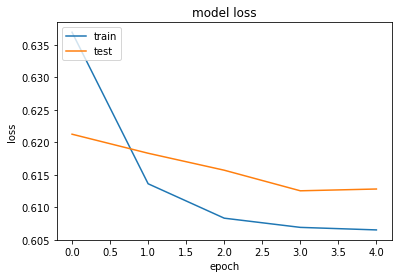

In [8]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

<h1>Show top 10 movie recommendations to a user</h1>

In [9]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 590
Movies with high ratings from user
--------------------------------
Forrest Gump (1994) : Comedy|Drama|Romance|War
Godfather, The (1972) : Crime|Drama
Wizard of Oz, The (1939) : Adventure|Children|Fantasy|Musical
Miracle on 34th Street (1947) : Comedy|Drama
Lord of the Rings: The Two Towers, The (2002) : Adventure|Fantasy
--------------------------------
Top 10 movie recommendations
--------------------------------
Léon: The Professional (a.k.a. The Professional) (Léon) (1994) : Action|Crime|Drama|Thriller
Ghost in the Shell (Kôkaku kidôtai) (1995) : Animation|Sci-Fi
Trainspotting (1996) : Comedy|Crime|Drama
Boogie Nights (1997) : Drama
Office Space (1999) : Comedy|Crime
Go (1999) : Comedy|Crime
Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001) : Comedy|Romance
Spirited Away (Sen to Chihiro no kamikakushi) (2001) : Adventure|Animation|Fantasy
Laputa: Castle in the Sky (Tenkû no shiro Rapyuta) (1986) : Action|Adventure|Animation|Children|Fantasy|